Early Spring Data Exploration 
========================

* Frame the problem and look at the big picture
* Get the data



### **Imports**

In [1]:
# All of your imports here 
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from IPython.display import display
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.stats import gaussian_kde
import os

### **Extra Functions To Use**

In [2]:
# def new_date_features(data):
 ##   data['year'] = data['date'].dt.year
 #   data['month'] = data['date'].dt.month
  #  data['day'] = data['date'].dt.day
 #   return data

def drop_enso_columns(data):

    features_to_drop = [
        'global temperature anomalies',
        'Nino 1+2 SST',
        'Nino 1+2 SST Anomalies',
        'Nino 3 SST',
        'Nino 3 SST Anomalies',
        'Nino 3.4 SST',
        'Nino 3.4 SST Anomalies',
        'Nino 4 SST',
        'Nino 4 SST Anomalies',
        'TNI',
        'PNA',
        'OLR',
        'SOI',
        'MEI.v2',
        'Season (2-Month)',
        'Season (3-Month)',
        'Season (12-Month)',
        'ENSO Phase-Intensity'
    ]

    data = data.drop(columns=features_to_drop)

    return data



### **Pivoting The Data**

In [3]:
def read_weather_data(filename):
    """
    Reads weather data from the given file. M values are assumed to be
    missing values (returned as nan). T values are trace values and returned as
    0.0025 inches for precipitation and snowfall and 0.025 inches for snowdepth
    (see https://www.chicagotribune.com/news/weather/ct-wea-asktom-0415-20180413-column.html).
    All temperatures are in Fahrenheit and all precipitation values are in inches.
    """
    def convert_precipitation(raw):
        return 0.0025 if raw == 'T' else np.nan if raw == 'M' else pd.to_numeric(raw)
    def convert_depth(raw):
        return 0.025 if raw == 'T' else np.nan if raw == 'M' else pd.to_numeric(raw)
    return pd.read_csv(filename, na_values=['M'], parse_dates=['date'],
        converters={
            "precipitation":convert_precipitation,
            "snowfall":convert_precipitation,
            "snowdepth":convert_depth,
        },
        names=["date","max_temp","min_temp","avg_temp","precipitation","snowfall","snowdepth"],
        header=0
    )

def pivot_enso():
    data = pd.read_csv('ENSO.csv', parse_dates=['date'])

    data = drop_enso_columns(data)
    dat = data.copy()
    dat['year'] = dat.date.dt.year  # TODO
    dat['year'] = dat.apply(lambda row: row['year'] + 1 if row['date'].month >= 3 else row['year'], axis=1) # trying to move months after february up one year.
    dat['month'] = dat.date.dt.month
    dat = dat.drop(columns=['date'])
    dat_pivoted = dat.pivot(index='year', columns='month')
    dat_pivoted.columns = ["_".join(str(x) for x in a) for a in dat_pivoted.columns.to_flat_index()]
    return dat_pivoted

def pivot_soil():
    data = pd.read_csv('soil.csv', parse_dates=['day'])

    dat = data.copy()
    dat['year'] = dat.day.dt.year
    dat['day_of_year'] = dat.day.dt.day_of_year
    # holder = dat['day']
    dat = dat.drop(columns=['day']).pivot(index='year', columns='day_of_year')
    dat.columns = ["_".join(str(x) for x in a) for a in dat.columns.to_flat_index()]
    # dat['day_of_year'] = holder.dt.day_of_year

    return dat

def pivot_weather():
    data = read_weather_data('weather.csv')

    dat = data.copy()
    print (dat.head())
    dat['year'] = dat.date.dt.year
    dat['day_of_year'] = dat.date.dt.day_of_year
    # holder = dat['date']
    dat = dat.drop(columns=['date']).pivot(index='year', columns='day_of_year')
    dat.columns = ["_".join(str(x) for x in a) for a in dat.columns.to_flat_index()]
    # dat['day_of_year'] = holder.dt.day_of_year

    return dat

#### **Merging The Data**

In [4]:
csv_files = [
    'early_spring.csv',
    'phil_pred.csv',
    'soil.csv',
    'weather.csv',
    'ENSO.csv'
]

def pivot_files():
    enso_pivoted = pivot_enso()
    soil_pivoted = pivot_soil()
    weather_pivoted = pivot_weather()

    return enso_pivoted, soil_pivoted, weather_pivoted

def process_file(df):
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
    elif 'day' in df.columns:
        df['day'] = pd.to_datetime(df['day'])
        df.rename(columns={'day': 'date'}, inplace=True)
    elif 'year' in df.columns:
        df['year'] = pd.to_datetime(df['year'], format='%Y')
        df.rename(columns={'year': 'date'}, inplace=True)
    return df

output_file = 'combined_data.csv'
combined_data = None

enso_pivoted, soil_pivoted, weather_pivoted = pivot_files()
phil_pred = pd.read_csv('phil_pred.csv')
early_spring = pd.read_csv('early_spring.csv')
# enso_pivoted = process_file(enso_pivoted)
# soil_pivoted = process_file(soil_pivoted)
# weather_pivoted = process_file(weather_pivoted)
# phil_pred = process_file(phil_pred)

datasets = [enso_pivoted, soil_pivoted, weather_pivoted, phil_pred, early_spring]

for df in datasets:
    if combined_data is None:
        combined_data = df
    else:
        combined_data = pd.merge(combined_data, df, how='outer', on='year')
        print(f"Processed {df.shape[1]} columns from {df.shape[0]} rows")

combined_data = combined_data.sort_values(by='year')

combined_data.to_csv(output_file, index=False)


        date  max_temp  min_temp  avg_temp  precipitation  snowfall  snowdepth
0 1947-01-01      30.0      24.0      27.0           0.12       0.5        1.0
1 1947-01-02      44.0      29.0      36.5           0.49       0.0        0.0
2 1947-01-03      54.0      41.0      47.5           0.04       0.0        NaN
3 1947-01-04      42.0      24.0      33.0           0.00       0.0        NaN
4 1947-01-05      33.0      25.0      29.0           0.00       0.0        NaN
Processed 336 columns from 70 rows
Processed 336 columns from 70 rows
Processed 2 columns from 70 rows
Processed 2 columns from 70 rows


# **Predicting Early Spring**

## Business Context
1. **Primary Objective**
   - Predict early spring occurrence before April 1st using weather and soil data
   - Goal: Enable data-driven business decisions for increased profits

2. **Current Solution & Usage**
   - Existing methods rely on traditional, less data-driven approaches
   - New solution will use daily local weather and soil data
   - Predictions must be made before April 1st annually

## Technical Framework
1. **Problem Classification**
   - Type: Supervised binary classification
   - Features: Weather and soil data
   - Requirements: System must adapt to climate changes over time
   - Advantage: Low risk of data manipulation due to weather-based inputs

2. **Performance Metrics**
   - Primary metric: Mean Absolute Error (MAE)
   - Minimum required accuracy: >65% for profitability
   - Benchmark: Must significantly outperform random guessing (50%)

3. **Methodology**
   - Leverage existing tools from:
     - Weather prediction models
     - Agricultural forecasting
     - Time series analysis
   - Manual approach: Compare historical patterns in temperature and related data to identify early spring indicators

## Assumptions & Considerations
1. **Key Assumptions**
   - Data collection is reliable and consistent across years
   - Climate change impact is gradual
   - 5-day period before April 1st is crucial for prediction

2. **Open Questions**
   - Availability of human expertise needs to be determined
   - Validation methods for assumptions
   - Integration with existing business processes

## Areas for Further Investigation
1. **Data Requirements**
   - Historical data availability and quality
   - Additional relevant data sources
   - Data collection and storage methods

2. **Implementation Strategy**
   - System deployment plan
   - Monitoring and maintenance requirements
   - Update/retraining schedule



---

# **Get the Data**

1. **List the data you need and how much you need:**
    - Historical weather data (temperature, precipitation, snowfall)
    - Soil temperature and moisture data
    - Early spring occurrence data
    - Groundhog Day predictions (if available)

2. **Find and document where you can get that data:**
    
    - N/A right now

3. **Get access authorizations**: Most of this data should be publicly available, but some soil data might require permission from agricultural departments.

4. **Create a workspace**: This notebook.

5. **Get the data**: 
    - Downloaded early_spring.csv, phil_pred.csv, soil.csv, and weather.csv files
    - These files contain the necessary historical data for our analysis

6. **Convert the data to a format you can easily manipulate**:
   - Data is provided in CSV files, which are easy to use with pandas
   - We've already merged the data into a single combined_data.csv file for easier manipulation

7. **Ensure sensitive information is deleted or protected**: The data appears to be anonymized and doesn't contain sensitive information.

8. **Check the size and type of data (time series, geographical, …)**: <mark>TODO</mark>: Report your information below. At this point, since you don't want to look at the data too closely, this is a quick evaluation about the number of features, the number of samples, and any special considerations about the features such as:
   1. Is it a time series? (Yes, the data is time-based with daily measurements)
   2. Are any of the features not available for the business problem? (We need to ensure we're only using data available before April 1st for predictions)
   3. Which feature(s) will be used as the target/label for the business problem? (The 'early_spring' column from early_spring.csv is likely our target variable)
   4. Should any of the features be stratified during the train/test split to avoid sampling biases? (We might want to stratify by year to ensure we have a good distribution of early spring and non-early spring years in both train and test sets)


#### **Load The Data**

In [5]:
data = pd.read_csv('combined_data.csv') 
data

,year,ONI_1,ONI_2,ONI_3,ONI_4,ONI_5,ONI_6,ONI_7,ONI_8,ONI_9,...,snowdepth_49,snowdepth_50,snowdepth_51,snowdepth_52,snowdepth_53,snowdepth_54,snowdepth_55,snowdepth_56,prediction,early_spring
0,1947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.000,9.000,7.0,7.000,8.000,6.000,False,False
1,1948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,NaN,NaN,3.0,0.025,0.000,NaN,False,False
2,1949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,False,True
3,1950,-1.5,-1.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.025,0.025,0.000,0.0,0.000,0.025,0.025,True,False
4,1951,-0.8,-0.5,-1.2,-1.2,-1.1,-0.9,-0.5,-0.4,-0.4,...,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,2020,0.5,0.5,0.7,0.7,0.5,0.5,0.3,0.1,0.2,...,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,True,True
74,2021,-1.1,-0.9,0.4,0.2,-0.1,-0.3,-0.4,-0.6,-0.9,...,4.000,4.000,4.000,4.000,4.0,3.000,1.000,0.000,False,True
75,2022,-1.0,-0.9,-0.8,-0.7,-0.5,-0.4,-0.4,-0.5,-0.7,...,0.025,0.000,1.000,0.025,0.0,0.000,0.000,0.000,False,True
76,2023,-0.7,-0.4,-1.0,-1.1,-1.0,-0.9,-0.8,-0.9,-1.0,...,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,False,True


#### **Looking At The Features**

In [6]:
data.shape

(78, 687)

#### **Dropping Features With Only Missing Values**

In [7]:
empty_columns = data.columns[data.isna().all()].tolist()
for column in empty_columns:
    print(f"Column {column} is empty. Dropping it.")
    data.drop(column, axis=1, inplace=True)

#### **Missing Percentages**

In [8]:
missing_percentage = data.isna().mean() * 100
print(missing_percentage)

year             0.000000
ONI_1            5.128205
ONI_2            5.128205
ONI_3            5.128205
ONI_4            5.128205
                  ...    
snowdepth_54    10.256410
snowdepth_55    11.538462
snowdepth_56    12.820513
prediction      10.256410
early_spring    10.256410
Length: 687, dtype: float64


 ### **Displaying The First 5 Rows Of The Data**

In [9]:
pd.set_option('display.max_columns', None)

data.head() 


,year,ONI_1,ONI_2,ONI_3,ONI_4,ONI_5,ONI_6,ONI_7,ONI_8,ONI_9,ONI_10,ONI_11,ONI_12,mean_soil_temp_1,mean_soil_temp_2,mean_soil_temp_3,mean_soil_temp_4,mean_soil_temp_5,mean_soil_temp_6,mean_soil_temp_7,mean_soil_temp_8,mean_soil_temp_9,mean_soil_temp_10,mean_soil_temp_11,mean_soil_temp_12,mean_soil_temp_13,mean_soil_temp_14,mean_soil_temp_15,mean_soil_temp_16,mean_soil_temp_17,mean_soil_temp_18,mean_soil_temp_19,mean_soil_temp_20,mean_soil_temp_21,mean_soil_temp_22,mean_soil_temp_23,mean_soil_temp_24,mean_soil_temp_25,mean_soil_temp_26,mean_soil_temp_27,mean_soil_temp_28,mean_soil_temp_29,mean_soil_temp_30,mean_soil_temp_31,mean_soil_temp_32,mean_soil_temp_33,mean_soil_temp_34,mean_soil_temp_35,mean_soil_temp_36,mean_soil_temp_37,mean_soil_temp_38,mean_soil_temp_39,mean_soil_temp_40,mean_soil_temp_41,mean_soil_temp_42,mean_soil_temp_43,mean_soil_temp_44,mean_soil_temp_45,mean_soil_temp_46,mean_soil_temp_47,mean_soil_temp_48,mean_soil_temp_49,mean_soil_temp_50,mean_soil_temp_51,mean_soil_temp_52,mean_soil_temp_53,mean_soil_temp_54,mean_soil_temp_55,mean_soil_temp_56,mean_soil_moisture_1,mean_soil_moisture_2,mean_soil_moisture_3,mean_soil_moisture_4,mean_soil_moisture_5,mean_soil_moisture_6,mean_soil_moisture_7,mean_soil_moisture_8,mean_soil_moisture_9,mean_soil_moisture_10,mean_soil_moisture_11,mean_soil_moisture_12,mean_soil_moisture_13,mean_soil_moisture_14,mean_soil_moisture_15,mean_soil_moisture_16,mean_soil_moisture_17,mean_soil_moisture_18,mean_soil_moisture_19,mean_soil_moisture_20,mean_soil_moisture_21,mean_soil_moisture_22,mean_soil_moisture_23,mean_soil_moisture_24,mean_soil_moisture_25,mean_soil_moisture_26,mean_soil_moisture_27,mean_soil_moisture_28,mean_soil_moisture_29,mean_soil_moisture_30,mean_soil_moisture_31,mean_soil_moisture_32,mean_soil_moisture_33,mean_soil_moisture_34,mean_soil_moisture_35,mean_soil_moisture_36,mean_soil_moisture_37,mean_soil_moisture_38,mean_soil_moisture_39,mean_soil_moisture_40,mean_soil_moisture_41,mean_soil_moisture_42,mean_soil_moisture_43,mean_soil_moisture_44,mean_soil_moisture_45,mean_soil_moisture_46,mean_soil_moisture_47,mean_soil_moisture_48,mean_soil_moisture_49,mean_soil_moisture_50,mean_soil_moisture_51,mean_soil_moisture_52,mean_soil_moisture_53,mean_soil_moisture_54,mean_soil_moisture_55,mean_soil_moisture_56,min_soil_temp_1,min_soil_temp_2,min_soil_temp_3,min_soil_temp_4,min_soil_temp_5,min_soil_temp_6,min_soil_temp_7,min_soil_temp_8,min_soil_temp_9,min_soil_temp_10,min_soil_temp_11,min_soil_temp_12,min_soil_temp_13,min_soil_temp_14,min_soil_temp_15,min_soil_temp_16,min_soil_temp_17,min_soil_temp_18,min_soil_temp_19,min_soil_temp_20,min_soil_temp_21,min_soil_temp_22,min_soil_temp_23,min_soil_temp_24,min_soil_temp_25,min_soil_temp_26,min_soil_temp_27,min_soil_temp_28,min_soil_temp_29,min_soil_temp_30,min_soil_temp_31,min_soil_temp_32,min_soil_temp_33,min_soil_temp_34,min_soil_temp_35,min_soil_temp_36,min_soil_temp_37,min_soil_temp_38,min_soil_temp_39,min_soil_temp_40,min_soil_temp_41,min_soil_temp_42,min_soil_temp_43,min_soil_temp_44,min_soil_temp_45,min_soil_temp_46,min_soil_temp_47,min_soil_temp_48,min_soil_temp_49,min_soil_temp_50,min_soil_temp_51,min_soil_temp_52,min_soil_temp_53,min_soil_temp_54,min_soil_temp_55,min_soil_temp_56,min_soil_moisture_1,min_soil_moisture_2,min_soil_moisture_3,min_soil_moisture_4,min_soil_moisture_5,min_soil_moisture_6,min_soil_moisture_7,min_soil_moisture_8,min_soil_moisture_9,min_soil_moisture_10,min_soil_moisture_11,min_soil_moisture_12,min_soil_moisture_13,min_soil_moisture_14,min_soil_moisture_15,min_soil_moisture_16,min_soil_moisture_17,min_soil_moisture_18,min_soil_moisture_19,min_soil_moisture_20,min_soil_moisture_21,min_soil_moisture_22,min_soil_moisture_23,min_soil_moisture_24,min_soil_moisture_25,min_soil_moisture_26,min_soil_moisture_27,min_soil_moisture_28,min_soil_moisture_29,min_soil_moisture_30,min_soil_moisture_31,min_soil_moisture_32,min_soil_moisture_33,min_soil_moisture_34,min_soil_moisture_35,min_soil_moisture_36,min_soi

#### **Correlation Heatmap Of Numeric Features**

- From what we can see the correlation matrix reveals strong relationships within soil temperature measures and within soil moisture measures, but weaker connections between temperature and moisture. For example, there's little correlation between soil conditions and time features like year, month, or day.
- This basically means that soil temperature and moisture levels are generally consistent on their own, but they don't always change in sync with each other and don't follow clear seasonal or time-based patterns

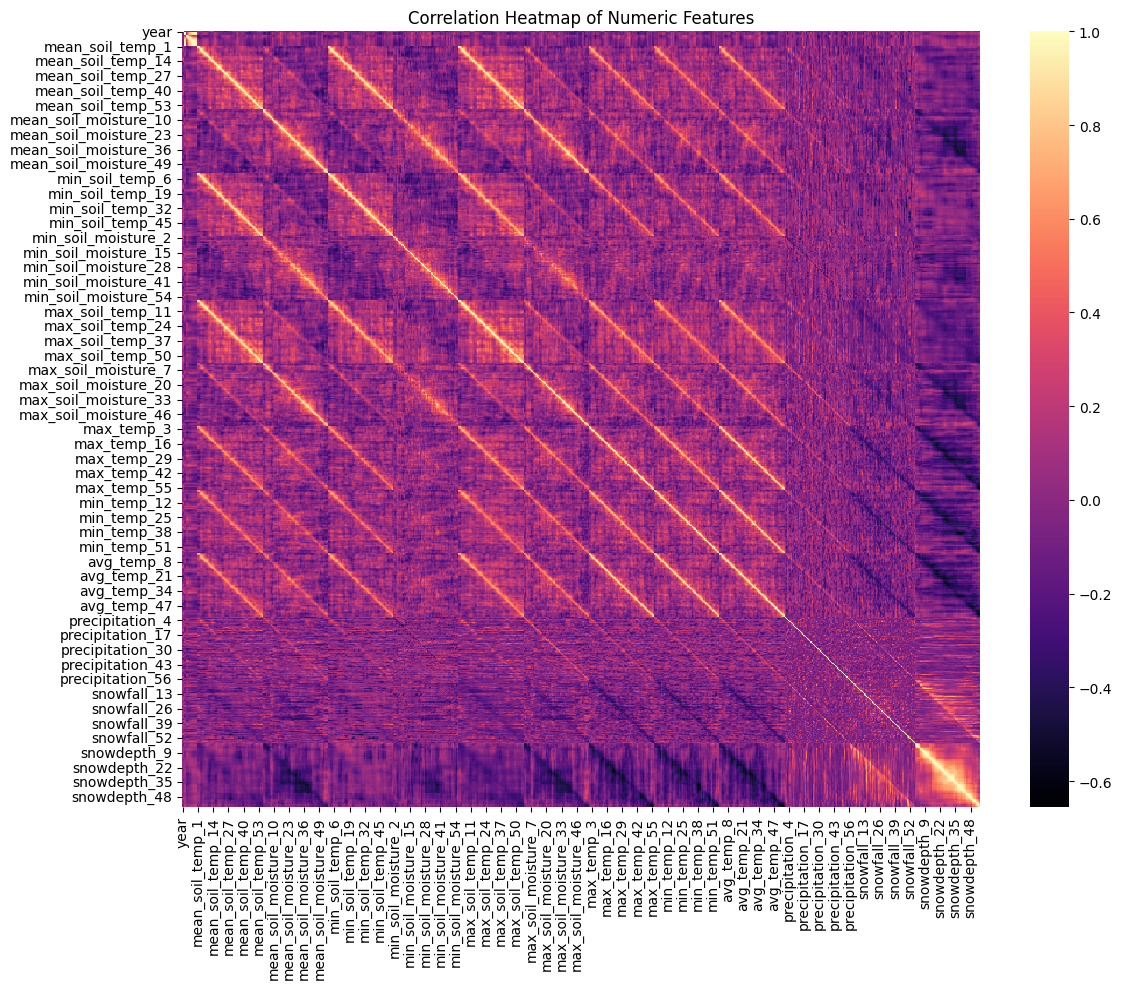

In [10]:
numeric_columns = data.select_dtypes(include=[np.number]).columns
correlation_matrix = data[numeric_columns].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='magma')
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()

#### **Correlation Heatmap Of Mean And Average Features**


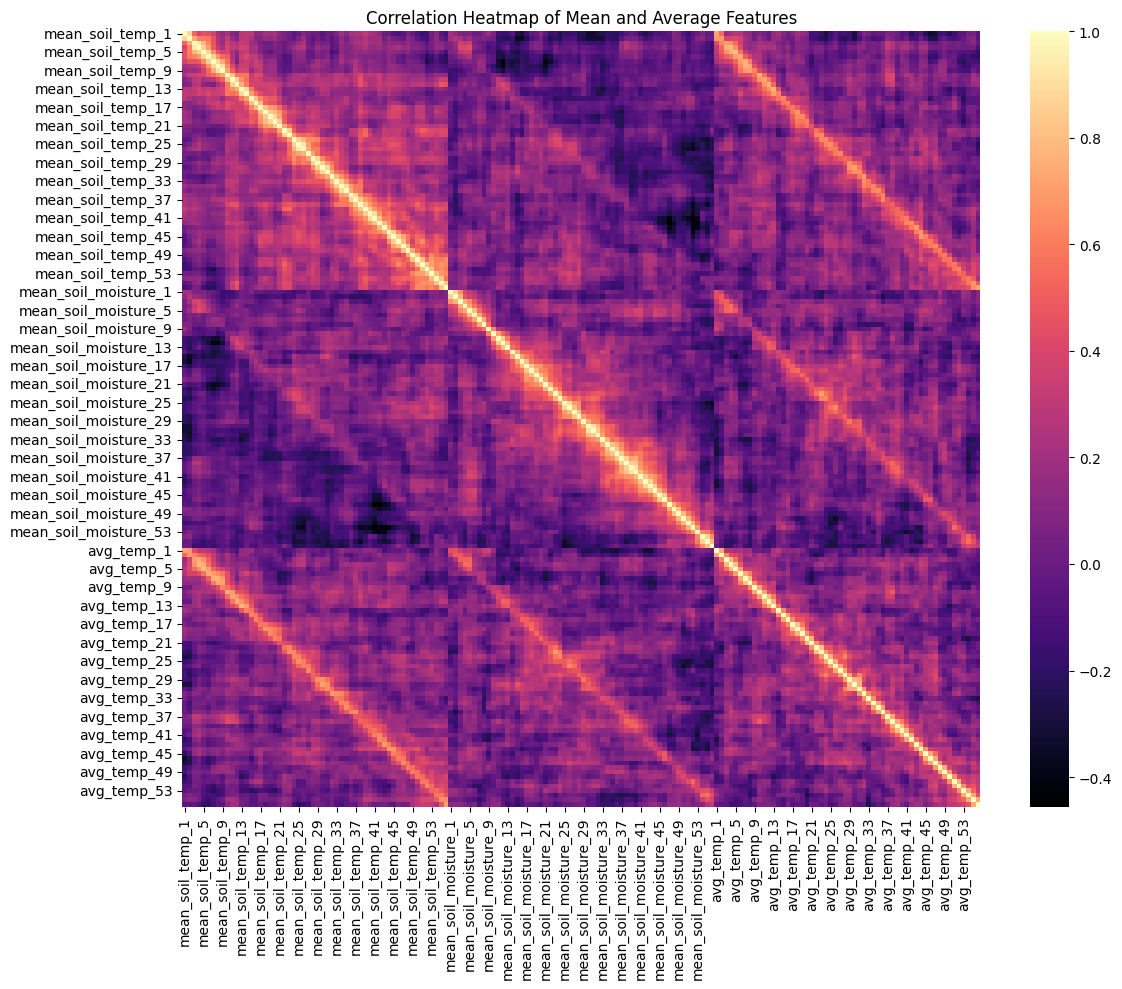

In [11]:
mean_columns = [mean for mean in data.columns if 'mean' in mean]
avg_columns = [avg for avg in data.columns if 'avg' in avg]
numeric_columns = data[mean_columns + avg_columns].select_dtypes(include=[np.number]).columns
correlation_matrix = data[numeric_columns].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='magma')
plt.title('Correlation Heatmap of Mean and Average Features')
plt.tight_layout()

### **Mean Soil Temperature Across Time Points**

- The graph shows soil temperatures from five locations, ranging from -10°C to +12°C over about 80 samples. The lines track closely together, indicating similar temperature changes. Notable spikes occur around samples 5, 50, and 75, with a drop between samples 65 and 70. Overall, soil temperatures are mostly consistent across the area, with minor differences between locations.


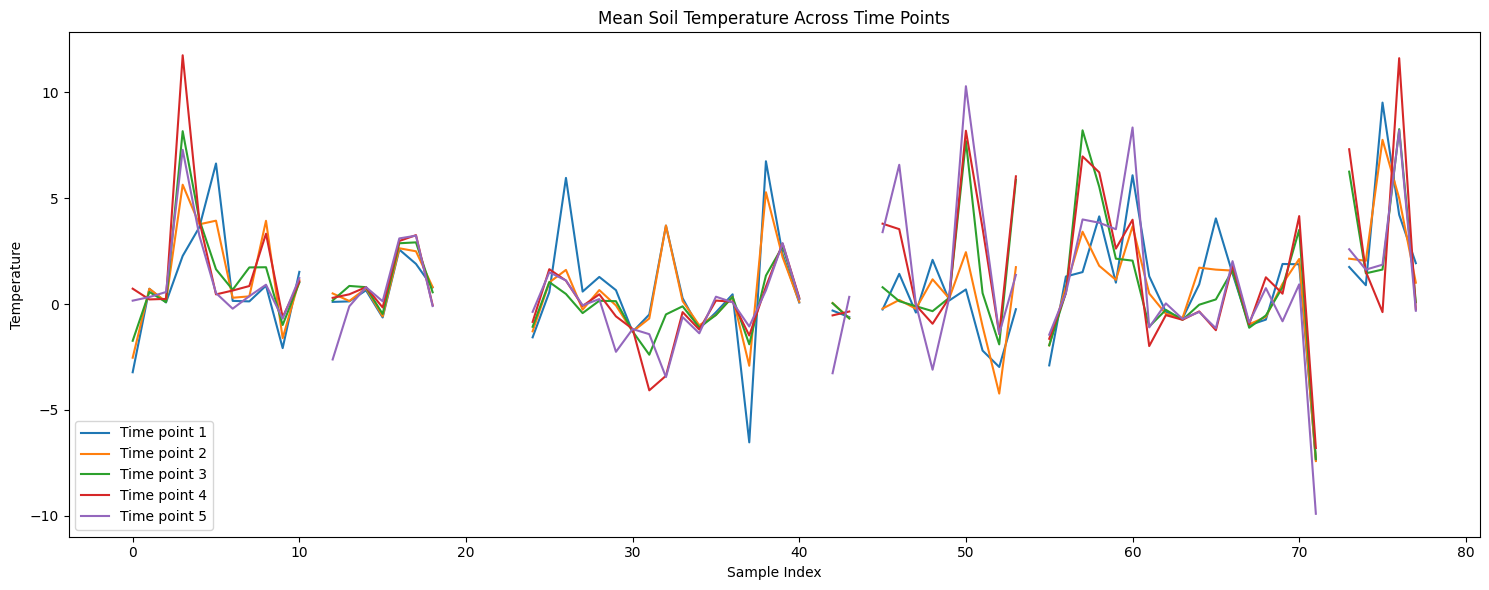

In [12]:
plt.figure(figsize=(15, 6))
soil_temp_cols = [col for col in data.columns if 'soil_temp' in col and 'mean' in col][:5]  # First 5 time points
for col in soil_temp_cols:
    plt.plot(data.index, data[col], label=f'Time point {col.split("_")[-1]}')
plt.title('Mean Soil Temperature Across Time Points')
plt.xlabel('Sample Index')
plt.ylabel('Temperature')
plt.legend()
plt.tight_layout()
plt.show()


Big gaps in the data, Samples with missing data from the original dataset get dropped in the pipeline.

### **Soil Moisture Distribution**

This boxplot displays soil moisture levels measured at five different times, ranging from about 0.44 to 0.51. The median moisture level (indicated by the red lines) is stable at around 0.47 across all time points. The similar sizes of the boxes and whiskers suggest that soil moisture is fairly consistent with little variation between measurements.


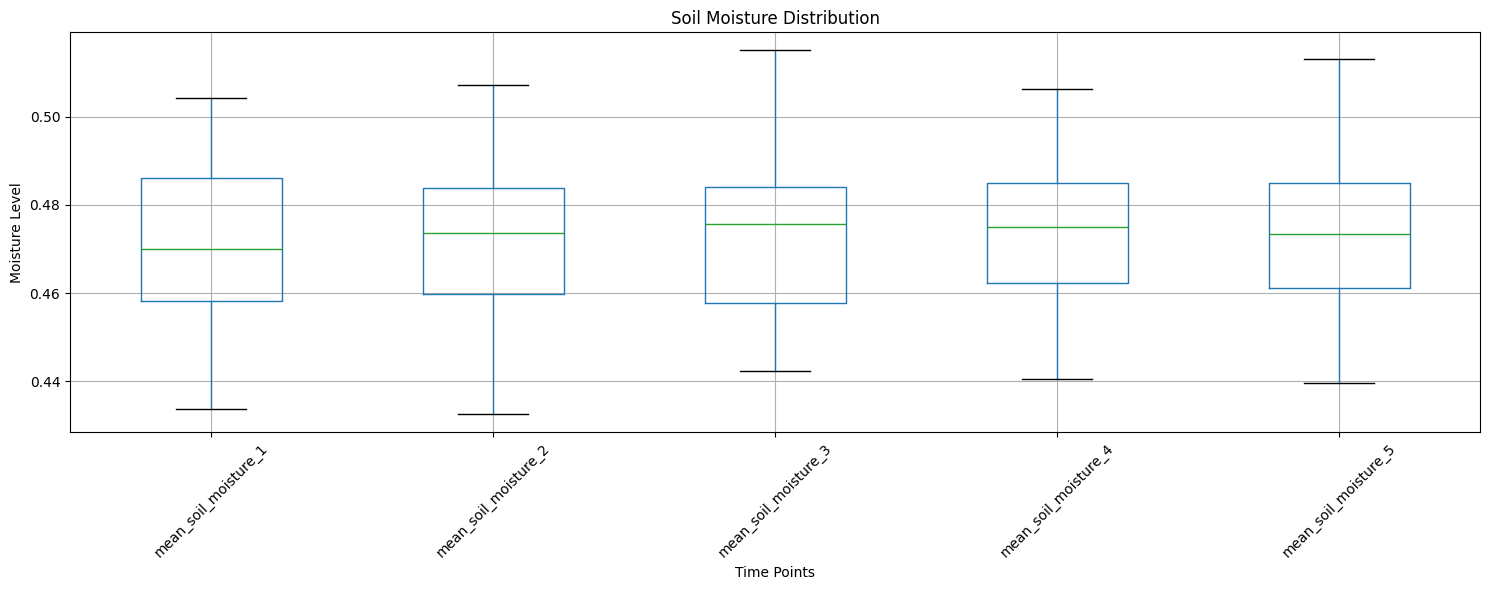

In [13]:
plt.figure(figsize=(15, 6))
moisture_cols = [col for col in data.columns if 'soil_moisture' in col and 'mean' in col][:5]
data[moisture_cols].boxplot()
plt.title('Soil Moisture Distribution')
plt.xlabel('Time Points')
plt.ylabel('Moisture Level')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### **Temperature Vs Moisture Relationship**


- This scatter plot shows the relationship between soil temperature (x-axis: -7.5°C to 10°C) and soil moisture (y-axis: 0.44 to 0.51), with color intensity indicating data density. Most points cluster around 0°C and 0.47-0.49 moisture levels, but there’s no strong linear relationship, suggesting the two variables are mostly independent.

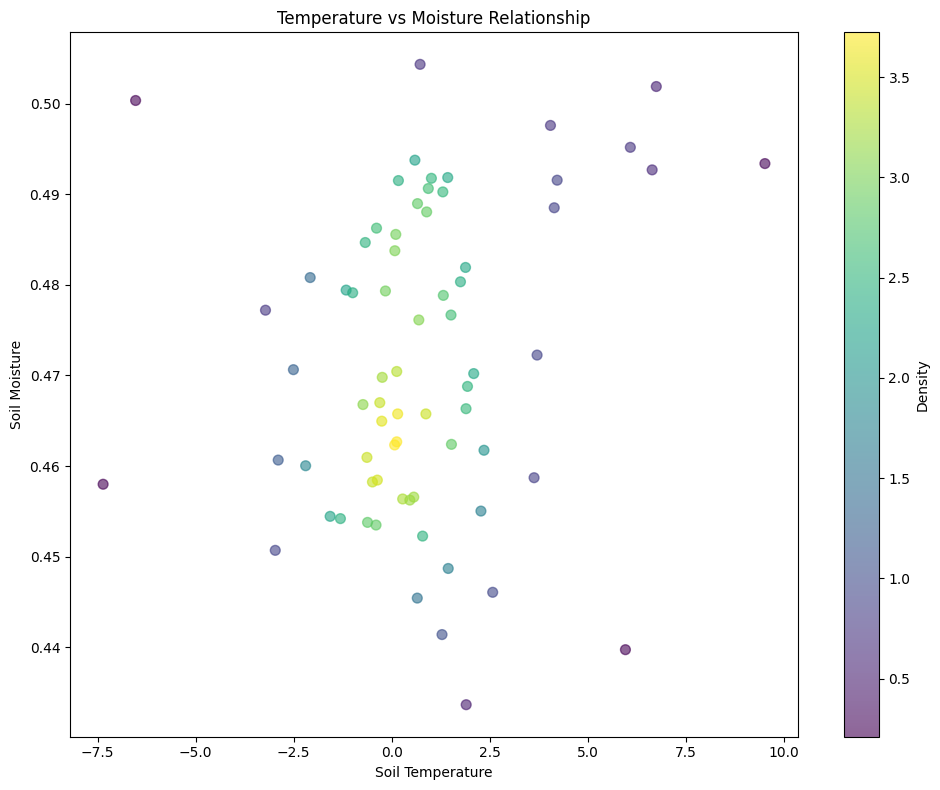

In [14]:
plt.figure(figsize=(10, 8))
if soil_temp_cols and moisture_cols:
    x = data[soil_temp_cols[0]]  # First time point
    y = data[moisture_cols[0]]
    
    # Remove any NaN values
    mask = ~(np.isnan(x) | np.isnan(y))
    x = x[mask]
    y = y[mask]
    
    # Create density scatter plot
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    
    scatter = plt.scatter(x, y, c=z, s=50, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label='Density')
    
plt.title('Temperature vs Moisture Relationship')
plt.xlabel('Soil Temperature')
plt.ylabel('Soil Moisture')
plt.tight_layout()
plt.show()


### **Soil Temperature Trend With Uncertainty**

The graph displays soil temperature changes from 1950 to 2020. The red line shows the average temperature, while the pink area shows how much the temperature can vary. You can see spikes in temperature around 1950, 1990, and 2015. Most of the time, the temperature stayed between -2.5°C and 5°C, but it dropped sharply to -7.5°C close to 2020.


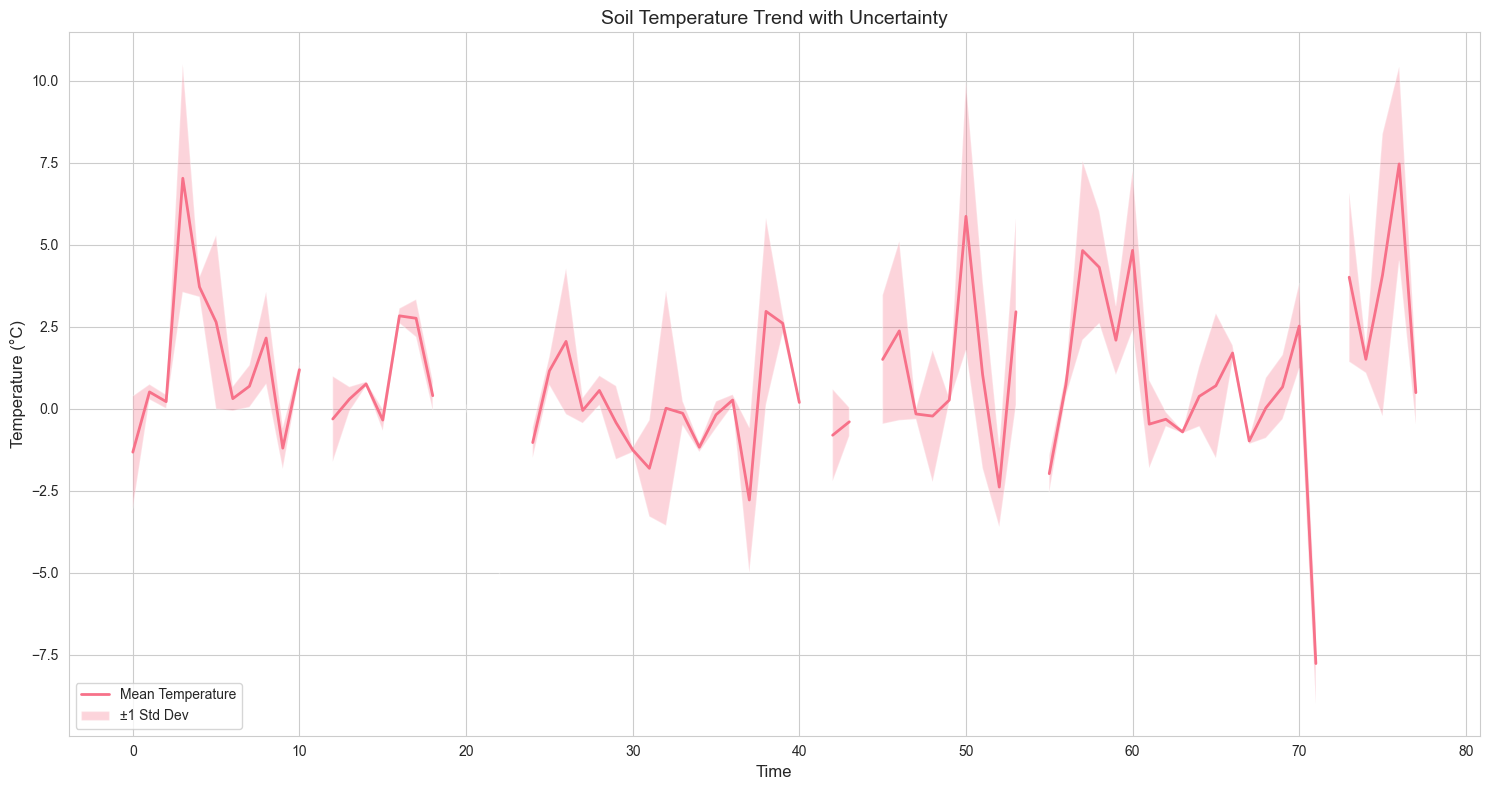

In [15]:
plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")
sns.set_palette("husl")

temp_mean = data[soil_temp_cols].mean(axis=1)
temp_std = data[soil_temp_cols].std(axis=1)

plt.plot(data.index, temp_mean, label='Mean Temperature', linewidth=2)
plt.fill_between(data.index, 
                 temp_mean - temp_std, 
                 temp_mean + temp_std, 
                 alpha=0.3,
                 label='±1 Std Dev')
plt.title('Soil Temperature Trend with Uncertainty', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

### **Temperature Vs Moisture With Distributions**


This graph shows the relationship between soil temperature (x-axis) and soil moisture (y-axis), with histograms on the sides showing how often each value appears. The red line shows a slight positive trend, meaning that as temperature increases, moisture tends to increase a little too. However, the points are scattered, so the relationship isn't strong. The histograms indicate that most temperatures are around 0°C, while moisture levels are mostly between 0.46 and 0.49.

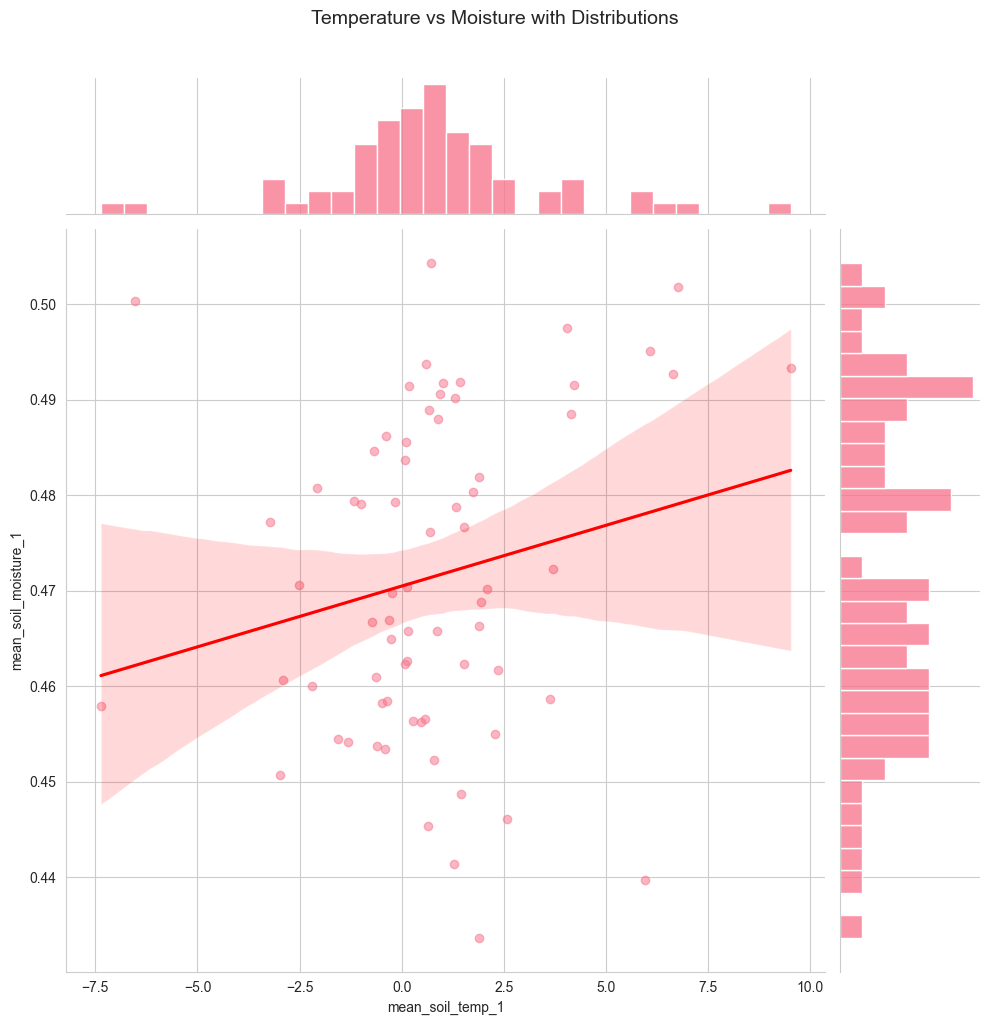

In [16]:
g = sns.JointGrid(data=data, 
                  x=soil_temp_cols[0],
                  y=moisture_cols[0],
                  height=10)
g = g.plot_joint(sns.regplot, 
                 scatter_kws={'alpha':0.5},
                 line_kws={'color': 'red'})
g = g.plot_marginals(sns.histplot, bins=30)
g.fig.suptitle('Temperature vs Moisture with Distributions', y=1.02, fontsize=14)
plt.tight_layout()


### **Temperature vs Moisture Density Distribution**


This density plot shows how soil temperature and moisture levels are distributed together. The bright yellow area around 0°C and 0.46 moisture indicates where most measurements are found. The colors range from purple (less common) to yellow (most common). There's also a purple spot at -5°C, showing a different group with higher moisture levels.

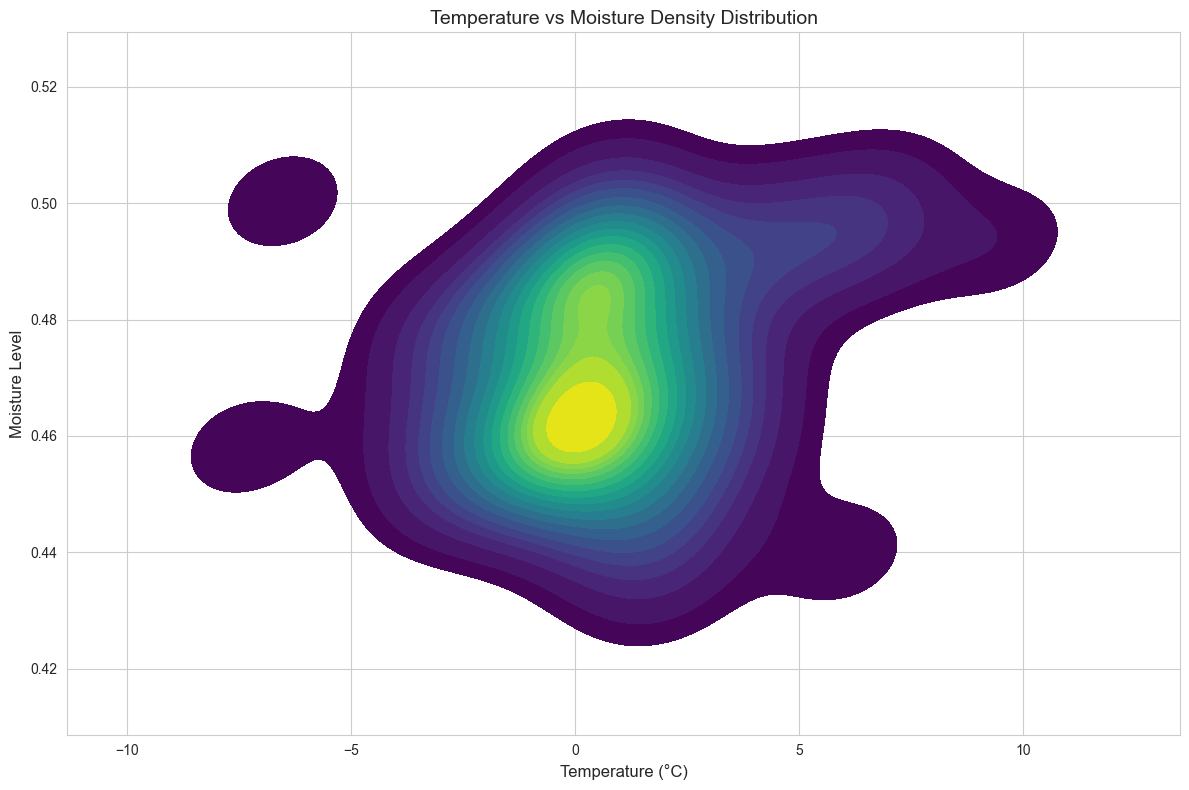

In [17]:
plt.figure(figsize=(12, 8))
sns.kdeplot(data=data,
            x=soil_temp_cols[0],
            y=moisture_cols[0],
            cmap='viridis',
            fill=True,
            levels=20)
plt.title('Temperature vs Moisture Density Distribution', fontsize=14)
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Moisture Level', fontsize=12)
plt.tight_layout()
plt.show()

#### **Splitting The Data**

In [18]:
def split_data():
    train_set, test_set = train_test_split(data, test_size=0.2, random_state=7)
    return train_set, test_set

In [19]:
train_set, test_set = split_data()
data = train_set.copy()

#### **Missing Percentages**

In [20]:
missing_percentage = data.isna().mean() * 100
print(missing_percentage)

year             0.000000
ONI_1            4.838710
ONI_2            4.838710
ONI_3            4.838710
ONI_4            4.838710
                  ...    
snowdepth_54    11.290323
snowdepth_55    12.903226
snowdepth_56    14.516129
prediction      11.290323
early_spring    11.290323
Length: 687, dtype: float64


# Prepare the Data

Note: the word *optional* simply means not all datasets will require it, it does not mean you can just choose not to do it if it is needed for a particular dataset.

- **A.** Data cleaning: Fix/remove outliers (optional); Fill in missing values (with 0, mean, median…) or drop rows/columns 
- **B.** Feature selection (optional): Drop attributes that provide no useful information for the task 
- **C.** Feature engineering, where appropriate: Discretize continuous features; Decompose features (categorical, date/time, …), Add promising transformations of features ($\log(x)$, $\sqrt{x}$, $x^2$, …); Aggregate features into promising new features 
- **D.** Feature scaling: standardize or normalize features 



### **Transformers**

## Regression Pipeline:

In [21]:
# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.impute import SimpleImputer
# import pandas as pd
# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer

# class DropSamplesOverThresholdTransformer(BaseEstimator, TransformerMixin):
#     """Drops samples with missing values over a certain threshold."""
#     def __init__(self):
#         pass

#     def fit(self, X, y=None):
#         return self
   
#     def transform(self, X):
#         X = X[X['year'] >= 1950]
#         return X

# class DropColumnsEmptyColumnsTransformer(BaseEstimator, TransformerMixin):
#     """Drops columns that are completely empty."""
#     def __init__(self):
#         pass
       
#     def fit(self, X, y=None):
#         return self
   
#     def transform(self, X):
#         empty_columns = X.columns[X.isna().all()].tolist()
#         for column in empty_columns:
#             print(f"Column {column} is empty. Dropping it.")
#             X.drop(column, axis=1, inplace=True)
#         return X
   
# class DropSamplesWithNoTargetTransformer(BaseEstimator, TransformerMixin):
#     """Drops samples with missing values in the target column."""
#     def __init__(self, target_column='target'):
#         self.target_column = target_column
       
#     def fit(self, X, y=None):
#         return self
   
#     def transform(self, X):
#         X = X.dropna(subset=[self.target_column])
#         return X

# class MICEImputerTransformer(BaseEstimator, TransformerMixin):
#     """Imputes missing values using Multivariate Imputation by Chained Equations (MICE)."""
   
#     def __init__(self, max_iter=10, random_state=None):
#         self.max_iter = max_iter
#         self.random_state = random_state
#         self.imputer = IterativeImputer(max_iter=self.max_iter, random_state=self.random_state)
       
#     def fit(self, X, y=None):
#         self.imputer.fit(X)
#         return self
   
#     def transform(self, X):
#         return self.imputer.transform(X)

# numerical_trans = Pipeline(steps=[
#         ('imputing', MICEImputerTransformer(random_state=7)),
#         ('scaling', StandardScaler())
#     ])

#     categorical_transformer = Pipeline(steps=[
#         ('impute', SimpleImputer(strategy='most_frequent')),
#         ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
#     ])

#     preprocessor = ColumnTransformer(transformers=[
#         ('num', numerical_trans, numerical_columns),
#         ('cat', categorical_transformer, categorical_columns)
#     ], remainder='passthrough')

#     data_cleaner = Pipeline(steps=[
#         ('drop_samples_over_threshold', DropSamplesOverThresholdTransformer()),
#         ('drop_empty_columns', DropColumnsEmptyColumnsTransformer())
#     ])

#     pipeline = Pipeline(steps=[ 
#         ('data_cleaning', data_cleaner),
#         ('preprocessing', preprocessor)
#     ])

#     return pipeline

# pipeline = create_preprocessing_pipeline(data)
# data_transformed = pipeline.fit_transform(data)

# pipeline

In [22]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

class DropSamplesOverThresholdTransformer(BaseEstimator, TransformerMixin):
    """Drops samples with year below a certain threshold."""
    def __init__(self, min_year=1950):
        self.min_year = min_year

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        before_shape = X.shape
        X = X[X['year'] >= self.min_year]
        after_shape = X.shape
        print(f"Dropped {before_shape[0] - after_shape[0]} samples based on year threshold.")
        return X

class DropColumnsEmptyColumnsTransformer(BaseEstimator, TransformerMixin):
    """Drops columns that are completely empty."""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        empty_columns = X.columns[X.isna().all()].tolist()
        for column in empty_columns:
            print(f"Column {column} is empty. Dropping it.")
            X.drop(column, axis=1, inplace=True)
        return X

class MICEImputerTransformer(BaseEstimator, TransformerMixin):
    """Imputes missing values using Multivariate Imputation by Chained Equations (MICE)."""
    def __init__(self, max_iter=10, random_state=None):
        self.max_iter = max_iter
        self.random_state = random_state
        self.imputer = IterativeImputer(max_iter=self.max_iter, random_state=self.random_state)

    def fit(self, X, y=None):
        self.imputer.fit(X)
        return self

    def transform(self, X):
        return self.imputer.transform(X)

def get_columns_by_type(X):
    numerical_columns = X.select_dtypes(include=['number']).columns.tolist()
    categorical_columns = X.select_dtypes(include=['object', 'category']).columns.tolist()
    return numerical_columns, categorical_columns

# Drop samples with missing target values from the original dataset
data = data.dropna(subset=['early_spring'])  # Ensure no missing target values

# Check if the 'early_spring' column is present
print(data.columns)

# Split the data into features and target before any transformations
X = data.drop(columns=['early_spring'])
y = data['early_spring']

# Ensure the DataFrame has the expected columns
print("Features columns:", X.columns)
print("Target column:", y.name)

# Proceed with the pipeline definition and fitting
numerical_columns, categorical_columns = get_columns_by_type(X)

numerical_trans = Pipeline(steps=[
    ('imputing', MICEImputerTransformer(random_state=7)),
    ('scaling', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_trans, numerical_columns),
    ('cat', categorical_transformer, categorical_columns)
], remainder='passthrough')

data_cleaner = Pipeline(steps=[
    ('drop_samples_over_threshold', DropSamplesOverThresholdTransformer()),
    ('drop_empty_columns', DropColumnsEmptyColumnsTransformer()),
])

# Apply data cleaning transformations to both X and y to ensure consistent sample sizes
# Ensure the target variable is categorical

X_cleaned = data_cleaner.fit_transform(X)
y_cleaned = y.loc[X_cleaned.index]

# Ensure the target variable is categorical
y_cleaned = y_cleaned.astype('category')

pipeline = Pipeline(steps=[ 
    ('data_cleaning', data_cleaner),
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression())  # Add classifier here
])

pipeline.fit(X_cleaned, y_cleaned)

data_transformed = pipeline.predict(X_cleaned)


Index(['year', 'ONI_1', 'ONI_2', 'ONI_3', 'ONI_4', 'ONI_5', 'ONI_6', 'ONI_7',
       'ONI_8', 'ONI_9',
       ...
       'snowdepth_49', 'snowdepth_50', 'snowdepth_51', 'snowdepth_52',
       'snowdepth_53', 'snowdepth_54', 'snowdepth_55', 'snowdepth_56',
       'prediction', 'early_spring'],
      dtype='object', length=687)
Features columns: Index(['year', 'ONI_1', 'ONI_2', 'ONI_3', 'ONI_4', 'ONI_5', 'ONI_6', 'ONI_7',
       'ONI_8', 'ONI_9',
       ...
       'snowdepth_48', 'snowdepth_49', 'snowdepth_50', 'snowdepth_51',
       'snowdepth_52', 'snowdepth_53', 'snowdepth_54', 'snowdepth_55',
       'snowdepth_56', 'prediction'],
      dtype='object', length=686)
Target column: early_spring
Dropped 2 samples based on year threshold.
Dropped 0 samples based on year threshold.


c:\Users\Colea\Desktop\CodingProjects\MachineLearning\SpringPredictor-ML\.venv\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Dropped 0 samples based on year threshold.


In [23]:
print(train_set['early_spring'].isnull().sum())
train_set = train_set.dropna(subset=['early_spring'])
print(train_set['early_spring'].isnull().sum())

7
0


### **Splitting The Data Into Features And Target**

In [24]:
X.head()

,year,ONI_1,ONI_2,ONI_3,ONI_4,ONI_5,ONI_6,ONI_7,ONI_8,ONI_9,ONI_10,ONI_11,ONI_12,mean_soil_temp_1,mean_soil_temp_2,mean_soil_temp_3,mean_soil_temp_4,mean_soil_temp_5,mean_soil_temp_6,mean_soil_temp_7,mean_soil_temp_8,mean_soil_temp_9,mean_soil_temp_10,mean_soil_temp_11,mean_soil_temp_12,mean_soil_temp_13,mean_soil_temp_14,mean_soil_temp_15,mean_soil_temp_16,mean_soil_temp_17,mean_soil_temp_18,mean_soil_temp_19,mean_soil_temp_20,mean_soil_temp_21,mean_soil_temp_22,mean_soil_temp_23,mean_soil_temp_24,mean_soil_temp_25,mean_soil_temp_26,mean_soil_temp_27,mean_soil_temp_28,mean_soil_temp_29,mean_soil_temp_30,mean_soil_temp_31,mean_soil_temp_32,mean_soil_temp_33,mean_soil_temp_34,mean_soil_temp_35,mean_soil_temp_36,mean_soil_temp_37,mean_soil_temp_38,mean_soil_temp_39,mean_soil_temp_40,mean_soil_temp_41,mean_soil_temp_42,mean_soil_temp_43,mean_soil_temp_44,mean_soil_temp_45,mean_soil_temp_46,mean_soil_temp_47,mean_soil_temp_48,mean_soil_temp_49,mean_soil_temp_50,mean_soil_temp_51,mean_soil_temp_52,mean_soil_temp_53,mean_soil_temp_54,mean_soil_temp_55,mean_soil_temp_56,mean_soil_moisture_1,mean_soil_moisture_2,mean_soil_moisture_3,mean_soil_moisture_4,mean_soil_moisture_5,mean_soil_moisture_6,mean_soil_moisture_7,mean_soil_moisture_8,mean_soil_moisture_9,mean_soil_moisture_10,mean_soil_moisture_11,mean_soil_moisture_12,mean_soil_moisture_13,mean_soil_moisture_14,mean_soil_moisture_15,mean_soil_moisture_16,mean_soil_moisture_17,mean_soil_moisture_18,mean_soil_moisture_19,mean_soil_moisture_20,mean_soil_moisture_21,mean_soil_moisture_22,mean_soil_moisture_23,mean_soil_moisture_24,mean_soil_moisture_25,mean_soil_moisture_26,mean_soil_moisture_27,mean_soil_moisture_28,mean_soil_moisture_29,mean_soil_moisture_30,mean_soil_moisture_31,mean_soil_moisture_32,mean_soil_moisture_33,mean_soil_moisture_34,mean_soil_moisture_35,mean_soil_moisture_36,mean_soil_moisture_37,mean_soil_moisture_38,mean_soil_moisture_39,mean_soil_moisture_40,mean_soil_moisture_41,mean_soil_moisture_42,mean_soil_moisture_43,mean_soil_moisture_44,mean_soil_moisture_45,mean_soil_moisture_46,mean_soil_moisture_47,mean_soil_moisture_48,mean_soil_moisture_49,mean_soil_moisture_50,mean_soil_moisture_51,mean_soil_moisture_52,mean_soil_moisture_53,mean_soil_moisture_54,mean_soil_moisture_55,mean_soil_moisture_56,min_soil_temp_1,min_soil_temp_2,min_soil_temp_3,min_soil_temp_4,min_soil_temp_5,min_soil_temp_6,min_soil_temp_7,min_soil_temp_8,min_soil_temp_9,min_soil_temp_10,min_soil_temp_11,min_soil_temp_12,min_soil_temp_13,min_soil_temp_14,min_soil_temp_15,min_soil_temp_16,min_soil_temp_17,min_soil_temp_18,min_soil_temp_19,min_soil_temp_20,min_soil_temp_21,min_soil_temp_22,min_soil_temp_23,min_soil_temp_24,min_soil_temp_25,min_soil_temp_26,min_soil_temp_27,min_soil_temp_28,min_soil_temp_29,min_soil_temp_30,min_soil_temp_31,min_soil_temp_32,min_soil_temp_33,min_soil_temp_34,min_soil_temp_35,min_soil_temp_36,min_soil_temp_37,min_soil_temp_38,min_soil_temp_39,min_soil_temp_40,min_soil_temp_41,min_soil_temp_42,min_soil_temp_43,min_soil_temp_44,min_soil_temp_45,min_soil_temp_46,min_soil_temp_47,min_soil_temp_48,min_soil_temp_49,min_soil_temp_50,min_soil_temp_51,min_soil_temp_52,min_soil_temp_53,min_soil_temp_54,min_soil_temp_55,min_soil_temp_56,min_soil_moisture_1,min_soil_moisture_2,min_soil_moisture_3,min_soil_moisture_4,min_soil_moisture_5,min_soil_moisture_6,min_soil_moisture_7,min_soil_moisture_8,min_soil_moisture_9,min_soil_moisture_10,min_soil_moisture_11,min_soil_moisture_12,min_soil_moisture_13,min_soil_moisture_14,min_soil_moisture_15,min_soil_moisture_16,min_soil_moisture_17,min_soil_moisture_18,min_soil_moisture_19,min_soil_moisture_20,min_soil_moisture_21,min_soil_moisture_22,min_soil_moisture_23,min_soil_moisture_24,min_soil_moisture_25,min_soil_moisture_26,min_soil_moisture_27,min_soil_moisture_28,min_soil_moisture_29,min_soil_moisture_30,min_soil_moisture_31,min_soil_moisture_32,min_soil_moisture_33,min_soil_moisture_34,min_soil_moisture_35,min_soil_moisture_36,min_soi

In [25]:
print(X.columns)

Index(['year', 'ONI_1', 'ONI_2', 'ONI_3', 'ONI_4', 'ONI_5', 'ONI_6', 'ONI_7',
       'ONI_8', 'ONI_9',
       ...
       'snowdepth_48', 'snowdepth_49', 'snowdepth_50', 'snowdepth_51',
       'snowdepth_52', 'snowdepth_53', 'snowdepth_54', 'snowdepth_55',
       'snowdepth_56', 'prediction'],
      dtype='object', length=686)


### **Removing Missing Values From X And Y**

 ### **Turn Categorical Columns Into One-Hot Encoded Columns**

# Classification:

In [26]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd

models = {
    'SupportVectorClassifier': SVC(),
    'RandomForestClassifier': RandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'BaggingClassifier': BaggingClassifier()
}

X = data.drop(columns=['early_spring'])
y = data['early_spring']

data_cleaned = data_cleaner.fit_transform(data)
data_transformed = preprocessor.fit_transform(data_cleaned)

print("Original y distribution:")
print(y.value_counts())

y_class = y.astype(int)
y_class = y_class.loc[data_cleaned.index]
print("New y_class distribution:")
print(y_class.value_counts())

if y_class.nunique() > 1:
    min_length = min(len(data_transformed), len(y_class))
    data_transformed = pd.DataFrame(data_transformed, index=data_cleaned.index[:min_length])
    y_class = y_class[:min_length]

    X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
        data_transformed, y_class, test_size=0.2, random_state=42, stratify=y_class
    )
    
    results = []
    for name, model in models.items():
        model.fit(X_train_class, y_train_class)
        y_pred_class = model.predict(X_test_class)
        report = classification_report(y_test_class, y_pred_class, output_dict=True)
        results.append((name, report))
        
        print(f"Model: {name}")
        print(classification_report(y_test_class, y_pred_class))

    for name, report in results:
        print(f"\n{name} Performance:")
        print(f"Precision: {report['1']['precision']:.2f}, Recall: {report['1']['recall']:.2f}, F1-score: {report['1']['f1-score']:.2f}")
else:
    print("The target variable y_class has only one unique class. Cannot fit the models.")


In [30]:
X = data.drop(columns=['early_spring'])
y = data['early_spring']

data_cleaned = data_cleaner.fit_transform(data)
data_transformed = preprocessor.fit_transform(data_cleaned)

y_class = y.astype(int).astype('category')
y_class = y_class.loc[data_cleaned.index]
print("New y_class distribution:")
print(y_class.value_counts())

min_length = min(len(data_transformed), len(y_class))
data_transformed = pd.DataFrame(data_transformed, index=data_cleaned.index[:min_length])

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X, y_class, test_size=0.2, random_state=42, stratify=y_class)

model = RandomForestClassifier()

model.fit(X_train_class, y_train_class)
y_pred_class = model.predict(X_test_class)
report = classification_report(y_test_class, y_pred_class, output_dict=True)
report

Dropped 2 samples based on year threshold.


KeyboardInterrupt: 